In [1]:
from qiskit_utils import *

## **Probing the nature of Boolean Functions !**

The Deusth-Josza algorithm gives aus an way of determining whether a given boolen fucntion $ \mathtt{f}: \{0,1\}^n \to \{1,0\} $ is balanced or constant, within a limited circuit depth. However, simply knowing a function to be balanced or constatnt doesn't reveal much about the nature of the boolean function itself, for example one might be interested in knowing what are the number of inputs $\mathtt{\vec{x}}$ such that $\: \mathtt{f(\vec{x}) = 1 }\: $ or $\: \mathtt{f(\vec{x}) = 0 }\:$ for that matter. Moreover assuming the $\: \mathtt{f} \:$, to be either balanced or constant comprises the wide range of possible boolean functions.

To deal with this I have made a slight modification to or regular DJ algorithm, such that it allows us to probe into the nature of the boolean function by recasting necessary information into the amplitude of ancilla qubits. Once we done, we can read off the required iinformation from the probability distribution of the ancilla qubit itself. Below I give a brief overview of the algorithm and then move on to an example implementation

#### **Algorithm**

For a boolean function $ \mathtt{f}: \{0,1\}^n \to \{1,0\} $ we have some input strings $\mathbf{ \vec{x} \in X_1}$ such that, $f(\mathbf{\vec{x}}) = 1 $ and some input strings  $\mathbf{\vec{x} \in X_0}$ such that $f(\mathbf{\vec{x}}) = 0 $. Our aim here is to estimate $n_1 = \mathbf{|X_1|}$ and $n_0 = \mathbf{|X_0|}$.

As is the regular DJ algorithm assume that we have a Phase Oracle $\mathbf{\hat{O}_{f}}$ implementing $\mathbf{\hat{O}_{f}} \ket{\vec{x}} = (-1)^{\mathtt{f(x)}} \ket{\vec{x}} $. We start the algorithm with the following elements,
- an ancilla $\ket{\mathtt{control}}$ initiated in $\ket{0}$
- an ancilla $\ket{\mathtt{oracle}}$ initiated in $\ket{-}$, which will be used to implement the phase oracle.
- a register to contain the data qubits $\ket{\vec{x}}$
- a classical register `creg`

In the procedure below we will represent the overall state in the form, $\: \ket{\psi} \:=\: \ket{\mathtt{control}} \otimes \ket{\vec{x}} \otimes \ket{\mathtt{oracle}} $  

**Step 1 :**  Apply hadamards to all the qubits in the data registers, to create an equal superposition of all basis states ; $\ket{\psi_0} = \ket{0} \otimes \sum_{i} \ket{\vec{x_i}} \otimes \ket{-}$, 

**Step 2 :**  Apply a hadamard $\mathbf{\hat{H}}$ on the $\ket{\mathtt{control}}$ register ; $ \ket{\psi_1} = \ket{+} \otimes \sum_{i} \ket{x_i} \otimes \ket{-} $

**Step 3:**   Controlled on the $\ket{\mathtt{control}}$ register apply the phase oracle on the data register; $ \ket{\psi_3} = \ket{0} \otimes \big( \sum_{i} \ket{x_i} \otimes \ket{-} \big) +  \ket{1} \otimes \big( \sum_{i} \mathbf{\hat{O_f}} \big( \ket{x_i} \otimes \ket{-} \big) \big) =   \ket{0} \otimes \sum_{i} \ket{x_i} \: + \: \ket{1} \otimes \big( \sum_{i} (-1)^{f(\vec{x})} \ket{x_i} \big) $ , where we have ignored the $\mathtt{\ket{oracle}}$ in the last expression.

Now the last expression can be recast into
$$ \ket{\psi_3}\:=\: \ket{0} \otimes \big( \sqrt{n_0}\mathbf{ \ket{X_0}} + \sqrt{n_1} \mathbf{ \ket{X_1} }  \big) \: + \: \ket{1} \otimes \big( \sqrt{n_0}\mathbf{ \ket{X_0}} - \sqrt{n_1} \mathbf{ \ket{X_1} }  \big)
$$ 
where $\mathbf{\ket{X_0}} = \sum_{\vec{x} \in X_0} \frac{1}{\sqrt{n_0}} \ket{\vec{x}} $ and $\mathbf{\ket{X_1}} = \sum_{\vec{x} \in X_1} \frac{1}{\sqrt{n_1}} \ket{\vec{x}} $, 


**Step 4:** Next we operate another Hadamard $\mathbf{\hat{H}}$ on the the $\mathtt{\ket{control}}$, with some algebra the resulting state can be written as,
$$  \ket{\psi_4} \:=\: \ket{0} \otimes \sqrt{n_0}\mathbf{\ket{X_0}} \:+\: \ket{1} \otimes \sqrt{n_1}\mathbf{\ket{X_1}}
$$

**Step 5:** Now we can simply measure the state of the $\mathtt{\ket{control}}$ to be in either $\ket{0}$ or $\ket{1}$ state , with probability 
$$  \mathbb{P}_{\ket{0}} \propto n_0 \;\;\; and \;\;\; \mathbb{P}_{\ket{1}} \propto n_1
$$

###### **NB :** in my calculations I have ignored overall normalisations unless specified.

#### **Example**

For our problem, $x \in \{0,1\}^4$ , and the oracle function is $f(x_1,x_2,x_3,x_4) = x_1x_2 + x_3x_4$

So out of all 16 possible values of $x$, there are 7 values such that $f(x) = 1$ and 9 values such that $f(x) = 0$.

Thus, $|X_1 |= 7$ and $|X_0| = 9$

In [2]:
def oracle_f(nq= 4):
    qreg, ancilla = QuantumRegister(nq), QuantumRegister(1)
    qc = QuantumCircuit(qreg, ancilla, name= 'oracle')
    qc.x(ancilla)
    qc.h(ancilla)
    qc.mcx([0,1], ancilla)
    qc.mcx([2,3], ancilla)
    qc.mcx([0,1,2,3], ancilla)
    qc.h(ancilla)
    qc.x(ancilla)
    return qc.to_gate()

In [3]:
qreg, ancilla_1, ancilla_2 , creg = QuantumRegister(4, name= 'qreg'), QuantumRegister(1, name= 'ancilla_1'), QuantumRegister(1, name= 'ancilla_2'), ClassicalRegister(1, name='creg')
qc = QuantumCircuit(qreg, ancilla_1, ancilla_2, creg)
qc.h(ancilla_2)
qc.h(qreg)
qc.barrier()
qc.append( oracle_f().control(1, label='controlled_oracle'),  [5,0,1,2,3,4])
qc.h(ancilla_2)

    
# qc.decompose().draw()        
qc.draw()    

┌───┐ ░     ┌─────────┐         
   qreg_0: ┤ H ├─░─────┤0        ├─────────
           ├───┤ ░     │         │         
   qreg_1: ┤ H ├─░─────┤1        ├─────────
           ├───┤ ░     │         │         
   qreg_2: ┤ H ├─░─────┤2 oracle ├─────────
           ├───┤ ░     │         │         
   qreg_3: ┤ H ├─░─────┤3        ├─────────
           └───┘ ░     │         │         
ancilla_1: ──────░─────┤4        ├─────────
           ┌───┐ ░     └────┬────┘    ┌───┐
ancilla_2: ┤ H ├─░──────────■─────────┤ H ├
           └───┘ ░  controlled_oracle └───┘
   creg: 1/════════════════════════════════

In [4]:
shots = 11024
qc.measure(ancilla_2, creg)
job = execute(qc, backend= aer, shots= shots)
counts = job.result().get_counts()
qc.draw()

┌───┐ ░     ┌─────────┐            
   qreg_0: ┤ H ├─░─────┤0        ├────────────
           ├───┤ ░     │         │            
   qreg_1: ┤ H ├─░─────┤1        ├────────────
           ├───┤ ░     │         │            
   qreg_2: ┤ H ├─░─────┤2 oracle ├────────────
           ├───┤ ░     │         │            
   qreg_3: ┤ H ├─░─────┤3        ├────────────
           └───┘ ░     │         │            
ancilla_1: ──────░─────┤4        ├────────────
           ┌───┐ ░     └────┬────┘    ┌───┐┌─┐
ancilla_2: ┤ H ├─░──────────■─────────┤ H ├┤M├
           └───┘ ░  controlled_oracle └───┘└╥┘
   creg: 1/═════════════════════════════════╩═
                                            0

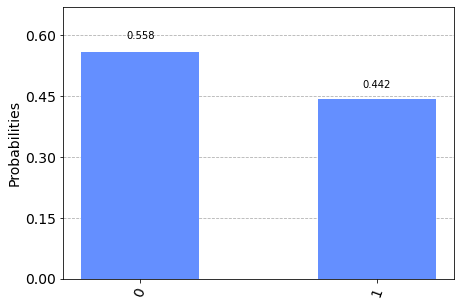

In [5]:
plot_histogram(counts)

In [6]:
print('|X1| :', counts['1']*16/shots)
print('|X0| :', counts['0']*16/shots)

|X1| : 7.076923076923077
|X0| : 8.923076923076923


Which is close enough to out orginal values!

#### **Conclusion**

** Note that we needed just one qubit measurement whereas in the usual DJ algotithm we would have needed to measure all the qubits in ```qreg```, also we didn't need the final layer of ```hadamard``` gates !